<a href="https://colab.research.google.com/github/vbhsharma7/stock_price_prediction/blob/main/stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [5]:
start_date = '2020-01-01'
end_date = '2023-06-10'
ticker = 'ADANIPORTS.NS'

df = yf.download(ticker, start=start_date, end=end_date)
df.tail(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-05,738.000000,744.0,735.000000,738.799988,738.799988,5166097
2023-06-06,742.900024,747.0,740.000000,745.400024,745.400024,5492469
2023-06-07,750.000000,751.0,741.950012,743.750000,743.750000,2129238
2023-06-08,744.950012,749.0,733.000000,736.400024,736.400024,2141709
2023-06-09,738.000000,742.0,733.000000,734.950012,734.950012,1335172



**Exploratory Data Analysis**

Mean: The average value of the opening or closing prices. A high mean value suggests that the stock is generally expensive, while a low mean value suggests that it is generally inexpensive.

Median: The middle value of the opening or closing prices. It represents the typical value of the stock prices and is less sensitive to outliers than the mean.

Standard Deviation: The measure of the spread of the opening or closing prices. A high standard deviation suggests that the stock prices are widely spread out, while a low standard deviation suggests that they are tightly clustered around the mean.

Maximum and Minimum values: The highest and lowest values of the opening or closing prices, respectively. These values provide information about the range of the stock prices and whether there have been any drastic changes in the stock price over time.

In [6]:
# Average,Median, STd , max  and min of Closing Price
print("Mean of closing price: ", df['Close'].mean())
print("Median of closing price: ", df['Close'].median())
print("Standard deviation of closing price: ", df['Close'].std())
print("Maximum value Of closing price: ",df['Close'].max())
print("Mininum value Of closing price: ",df['Close'].min())

Mean of closing price:  622.3687720226266
Median of closing price:  703.7000122070312
Standard deviation of closing price:  194.10645063653212
Maximum value Of closing price:  970.25
Mininum value Of closing price:  207.8000030517578


In [7]:
# Average,Median, STd , max  and min of Open Price 
print("Mean of Opening price: ", df['Open'].mean())
print("Median of Opening price: ", df['Open'].median())
print("Standard deviation of Opening price: ", df['Open'].std())
print("Maximum value Of Opening price: ",df['Open'].max())
print("Mininum value Of Opening price: ",df['Open'].min())

Mean of Opening price:  623.5828666285464
Median of Opening price:  702.9500122070312
Standard deviation of Opening price:  195.01249289037315
Maximum value Of Opening price:  974.2000122070312
Mininum value Of Opening price:  216.0


In [8]:
# Percent Return Of Closing Price
returns = df['Close'].pct_change()
returns.head()

Date
2020-01-01         NaN
2020-01-02    0.014564
2020-01-03   -0.001696
2020-01-06   -0.006013
2020-01-07    0.012099
Name: Close, dtype: float64

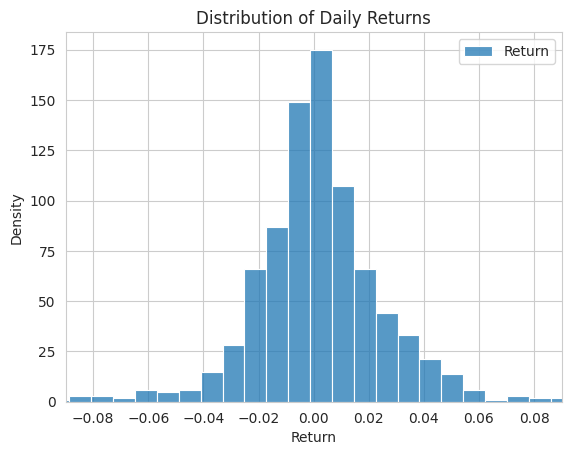

In [9]:
sns.histplot(returns[1:], bins=40,label='Return')
plt.xlabel('Return')  
plt.ylabel('Density')
plt.title('Distribution of Daily Returns')
plt.legend()
plt.gca().set_xlim(-0.09, 0.09)
plt.show()

In [10]:
# Date With Lowest and Highest Returns
print(returns.idxmin())
print(returns.idxmax())

2023-02-01 00:00:00
2021-04-06 00:00:00


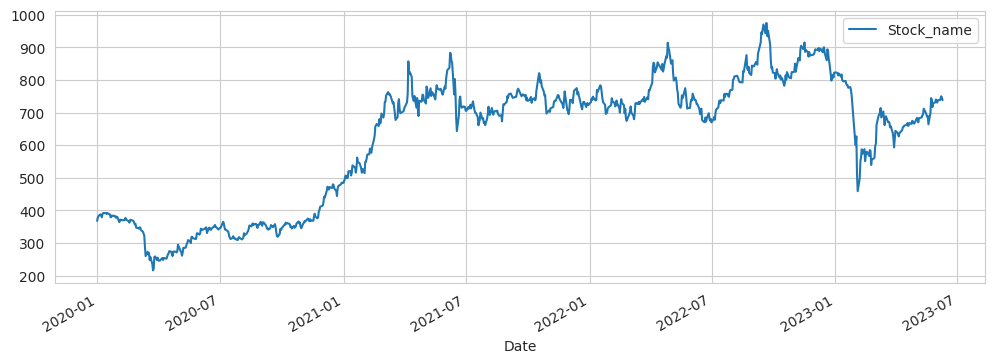

In [11]:
Open_price = df['Open']
Open_price.plot(label="Stock_name",figsize=(12,4))
plt.legend()

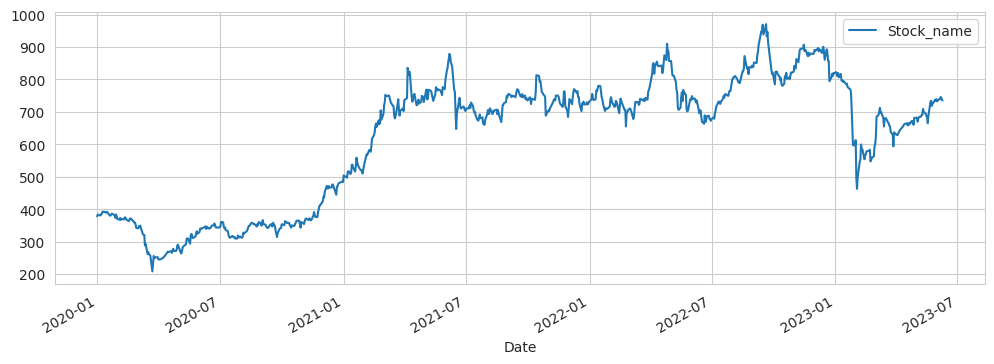

In [12]:
Closed_price = df['Close']
Closed_price.plot(label="Stock_name",figsize=(12,4))
plt.legend()


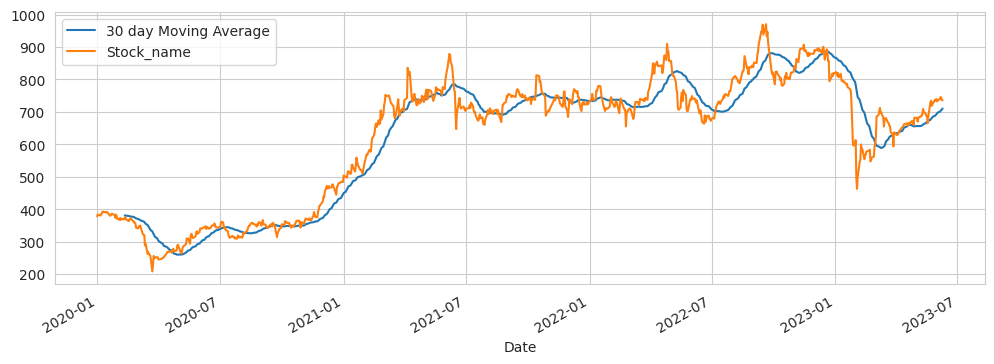

In [13]:
plt.figure(figsize=(12,4))
df['Close'].rolling(window=30).mean().plot(label='30 day Moving Average')
df['Close'].plot(label='Stock_name')
plt.legend()

In [14]:
df1=df.reset_index()['Close']


In [15]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [17]:
training_size,test_size

(555, 300)

In [18]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
len(train_data)

555

In [20]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape), print(y_train.shape)

(454, 100)
(454,)


(None, None)

In [22]:
print(X_test.shape), print(ytest.shape)

(199, 100)
(199,)


(None, None)

In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [26]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
8/8 [==============================] - 11s 447ms/step - loss: 0.1658 - val_loss: 0.0483
Epoch 2/100
8/8 [==============================] - 2s 230ms/step - loss: 0.0256 - val_loss: 0.0485
Epoch 3/100
8/8 [==============================] - 2s 230ms/step - loss: 0.0173 - val_loss: 0.0098
Epoch 4/100
8/8 [==============================] - 3s 371ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 5/100
8/8 [==============================] - 2s 226ms/step - loss: 0.0053 - val_loss: 0.0101
Epoch 6/100
8/8 [==============================] - 2s 198ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 7/100
8/8 [==============================] - 2s 226ms/step - loss: 0.0027 - val_loss: 0.0088
Epoch 8/100
8/8 [==============================] - 2s 209ms/step - loss: 0.0022 - val_loss: 0.0089
Epoch 9/100
8/8 [==============================] - 2s 224ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 10/100
8/8 [==============================] - 2s 294ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 11

In [28]:
import tensorflow as tf

In [29]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

7/7 [==============================] - 0s 36ms/step


In [30]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [31]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

614.4066568479938

In [32]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

734.3664845700304

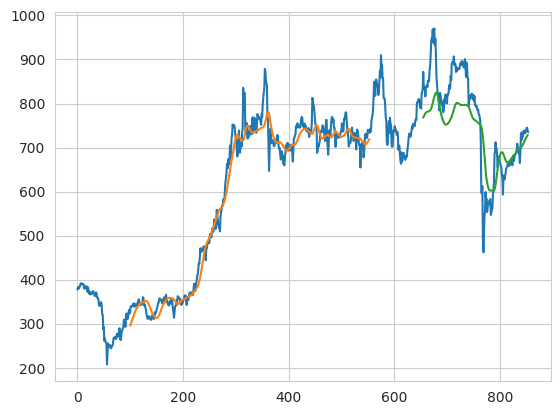

In [33]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [34]:
len(test_predict)

199

In [35]:
x_input=test_data[len(test_predict)-100:].reshape(1,-1)
x_input.shape

(1, 201)

In [36]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
from numpy import array

lst_output=[]
n_steps=len(x_input)
i=0
while(i<120):
    
    if(len(temp_input)>100):
        # print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        # x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.87087676 0.82949702 0.81933241 0.82431633 0.79769165 0.82615255
 0.82444754 0.83198901 0.82628367 0.8448423  0.84346518 0.84274375
 0.87494265 0.88825495 0.91684697 0.95835792 0.97186699 0.97062099
 0.99777033 0.95796447 0.98603184 1.         0.95101321 0.96904718
 0.92596234 0.85985969 0.8346777  0.81224995 0.79821631 0.80379044
 0.75624634 0.80693814 0.80831527 0.79887209 0.78733028 0.773231
 0.78182179 0.75670536 0.75060656 0.75860714 0.78975672 0.78333004
 0.80300346 0.77887078 0.78392026 0.77716568 0.80457735 0.80333135
 0.80759392 0.83152992 0.82051285 0.82110299 0.85920391 0.84621942
 0.89579643 0.8992721  0.90064922 0.90137057 0.91691262 0.89127153
 0.89586199 0.89330451 0.87061443 0.88484492 0.87323756 0.87723788
 0.88110693 0.87979536 0.87927079 0.88294314 0.89546854 0.8923864
 0.89887865 0.90320678 0.89048462 0.89855076 0.89573087 0.8833366
 0.90104267 0.90858415 0.88681227 0.85599057 0.89848511 0.88720572
 0.85231822 0.85133455 0.76896842 0.7846416  0.7991999

In [39]:
day_new=np.arange(1,len(x_input[0])+1)
day_pred=np.arange(len(x_input[0])+1,len(x_input[0])+121)

In [40]:
print(len(x_input[0]))
print(day_new.shape)
print(day_pred.shape)

200
(200,)
(120,)


In [41]:
len(df1)

855

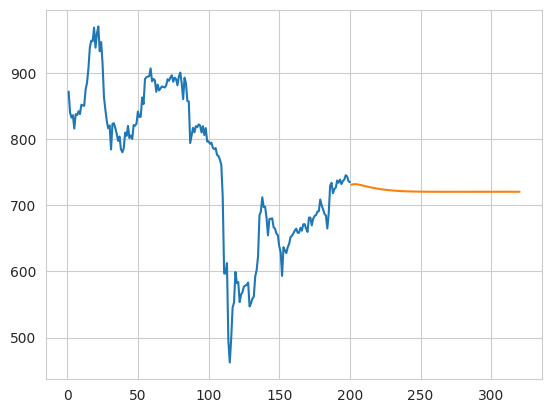

In [42]:

plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-len(x_input[0]):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
